<a href="https://colab.research.google.com/github/franconoronha/treinamento-h2ia/blob/main/9_Arvores_Decisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado de Máquina Supervisionado
## Árvores de Decisão ID3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


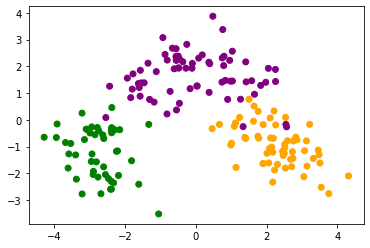

In [2]:
wine = load_wine()
data = pd.DataFrame(wine.data)
data_array = wine.data
target = wine.target

data_array = StandardScaler().fit_transform(data)
pca = PCA(n_components=2)
data_plot = pca.fit_transform(data_array)

colors = ["orange", "purple", "green"]
plt.scatter(data_plot[:,0], data_plot[:,1], c = [colors[i] for i in target])

t = np.reshape(target, (len(target),1))
data_array = np.append(data_array, t, axis=1)

data["label"] = target
data.head()

In [45]:
np.random.shuffle(data_array)
training_data = data_array[:125]
test_data = data_array[125:]


In [42]:
N_features = data_array.shape[1] - 1

def melhor_corte(array, features):
  corte = 0
  part_1r = []
  part_2r = []
  feature = -1
  folha = (False,False)
  min_gini = np.inf
  
  for feat in features:
    medias = []
    array = array[array[:, feat].argsort()] # ordenando pela coluna especifica
    valores_feature = array[:,feat]
    unicos = np.unique(valores_feature)
    for x in range(0, len(unicos) - 1):
      medias.append(np.mean(unicos[x:x+2]))

    for i, val in enumerate(medias):
      part_1 = array[np.where(valores_feature < val)]
      targets_1 = np.array([np.count_nonzero(part_1[:, 13] == x) for x in range(0, 3)])
      
      part_2 = array[np.where(valores_feature >= val)]
      targets_2 = np.array([np.count_nonzero(part_2[:, 13] == x) for x in range(0, 3)])

      gini_1 = 1 - np.square(targets_1[0] / len(part_1)) - np.square(targets_1[1] / len(part_1)) - np.square(targets_1[2] / len(part_1)) 
      gini_2 = 1 - np.square(targets_2[0] / len(part_2)) - np.square(targets_2[1] / len(part_2)) - np.square(targets_2[2] / len(part_2)) 

      gini = (len(part_1) / len(array)) * gini_1 + (len(part_2) / len(array)) * gini_2

      if gini < min_gini:
        folha = (np.count_nonzero(targets_1 == 0) == 2, np.count_nonzero(targets_2 == 0) == 2)
        min_gini = gini
        part_1r = part_1
        part_2r = part_2
        corte = val
        feature = feat

  return {
      "feature": feature,
      "folha": folha,
      "min_gini": min_gini,
      "part_1": part_1r,
      "part_2": part_2r,
      "corte": corte
  }

In [43]:
class Arvore_decisao:
  def __init__(self, array):
    self.array = array
    self.children = []
    self.feature = -1
    self.corte = 0
    self.classe = -1


def gerar_arvore(data):
  features = list(range(0, 13))
  arvore = Arvore_decisao(data)
  fila = [arvore]
  while len(features) and len(fila):
    atual = fila.pop(0)
    resultado = melhor_corte(atual.array, features)
    features.remove(resultado["feature"])
    atual.feature = resultado["feature"]
    atual.corte = resultado["corte"]
  
    part_1 = Arvore_decisao(resultado["part_1"])
    if resultado["folha"][0]:
      part_1.classe = part_1.array[0,13]
    else:
      fila.append(part_1)
    atual.children.append(part_1)

    part_2 = Arvore_decisao(resultado["part_2"])
    if resultado["folha"][1]:
      part_2.classe = part_2.array[0,13]
    else:
      fila.append(part_2)
    atual.children.append(part_2)
  
  pilha = [arvore]
  cont = 0
  while len(pilha): # calcular a classe dos nodos que ficaram sem filhos
    atual = pilha.pop()
    pilha.extend(atual.children)
    if not len(atual.children):
      atual.classe = np.bincount(atual.array[:,13].astype(int)).argmax()

  return arvore

In [46]:
arvore = gerar_arvore(training_data)

def classificar(arvore, ponto):
  while len(arvore.children): # nodo sem filhos = folha
    if ponto[arvore.feature] < arvore.corte:
      arvore = arvore.children[0]
    else:
      arvore = arvore.children[1]

  return arvore.classe

def avaliar(arvore, test_data):
  matriz_confusao = np.zeros((3,3))
  for p in test_data:
    matriz_confusao[int(p[13]), classificar(arvore, p)] += 1 # valor real, predicao

  total = matriz_confusao.sum()
  TP = matriz_confusao.diagonal().sum()
  print(matriz_confusao)
  print(f"Acurácia: {TP / total}")

avaliar(arvore, test_data)

[[12.  0.  0.]
 [ 3. 22.  0.]
 [ 0.  1. 15.]]
Acurácia: 0.9245283018867925
